In [38]:
#!pip install elasticsearch-dsl
#!pip install cassandra-driver
#!pip install elasticsearch
#!pip install confluent-kafka

In [36]:
from confluent_kafka import Consumer
from elasticsearch import Elasticsearch
from cassandra.cqlengine import connection
from cassandra.cluster import Cluster
from cassandra.policies import TokenAwarePolicy, RoundRobinPolicy
from elasticsearch_dsl import Search
from elasticsearch_dsl import A


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from IPython.display import Markdown, display

# Magic for displaying graphs and charts
%matplotlib inline
def printmd(string):
    display(Markdown(string))
import seaborn as sns

In [4]:
# Apache Cassandra connection
list_of_ip = (['192.168.56.101', '192.168.56.102', '192.168.56.103'])
cluster = Cluster(list_of_ip,load_balancing_policy=TokenAwarePolicy(RoundRobinPolicy()))
session = cluster.connect()
session.set_keyspace('thirdeye_test')
connection.set_session(session)

C:\Users\harii\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Legacy execution parameters will be removed in 4.0. Consider using execution profiles.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# Elasticsearch connection
es = Elasticsearch()

## 1. Simple

### 1.1 What is the min/max/average delays for an airline on a given day/month/year? 

In [6]:
#Query primary nosql (cassandra)
sql = "select MAX(arrdelayminutes) as max_delay, \
    MIN(arrdelayminutes) as min_delay, \
    AVG(arrdelayminutes) as avg_delay \
    from thirdeye_test.airlineontime where  \
    year=2017 and month = 1 and dayofmonth=1 ALLOW FILTERING"

rows = session.execute(sql)
for row in rows:
    print (row)

{'max_delay': 388, 'min_delay': 0, 'avg_delay': 16}


In [7]:
#Query secondary nosql (ES)
s = Search(using=es, index="my-index") \
    .query("match", Year=2017) \
    .query("match", Month=1) \
    .query("match", DayofMonth=1)

a = A('terms', field='ArrDelayMinutes')
a.metric('avg_delay', 'avg', field='ArrDelayMinutes')\
    .bucket('max_delay', 'max', field='ArrDelayMinutes')
s.aggs.bucket('category_terms', a)

print(s.to_dict())
response = s.execute()
for hit in response:
    print(hit)

{'query': {'bool': {'must': [{'match': {'Year': 2017}}, {'match': {'Month': 1}}, {'match': {'DayofMonth': 1}}]}}, 'aggs': {'category_terms': {'terms': {'field': 'ArrDelayMinutes'}, 'aggs': {'avg_delay': {'avg': {'field': 'ArrDelayMinutes'}}, 'max_delay': {'max': {'field': 'ArrDelayMinutes'}}}}}}
<Hit(my-index/MTRE0XABWCivyfFAf-fq): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/NjRE0XABWCivyfFAgOcJ): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/czRE0XABWCivyfFAged0): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/ijRE0XABWCivyfFAgef-): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/mjRE0XABWCivyfFAgudd): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/tDRE0XABWCivyfFAguf1): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofMonth': 1, 'D...}>
<Hit(my-index/tjRE0XABWCivyfFAg-cB): {'Year': 2017, 'Quarter': 1, 'Month': 1, 'DayofM

### 1.2 Top 3 Airlines that did not report the aircraft tail number (Aircraft tail number was null)

In [8]:
#Query primary nosql (cassandra)
sql = "select flight_date, max(arrdelayminutes) from thirdeye_test.airlineontime \
where flight_date='2017-01-01' AND  tail_number = 'NaN' \
GROUP BY flight_date \
ALLOW FILTERING"

rows = session.execute(sql)
for row in rows:
    print (row)
    

In [9]:
#Query secondary nosql (ES)


### 1.3 Were there any specific airport with maximum delays on a given day?

In [76]:
#Query primary nosql (cassandra)
sql = "select destinationcityname, CarrierDelay from thirdeye_test.airlineontime \
        where  CarrierDelay > 0 and year=2017 and month =1 and dayofmonth = 5 \
        ALLOW FILTERING"

#Application logic as I can not do aggreation over destinationcityname. Also, DISTINCT is possible only on primary key
d = {}
df = pd.DataFrame(data=d)
print(df.shape)
columns = list(df)
row_list = []

rows = session.execute(sql)
for row in rows:
    data = {
             'destinationcityname' : row['destinationcityname'],
             'CarrierDelay' :  row['carrierdelay']
         }
    df = df.append(data, ignore_index=True)
#print(df.shape)
#print(df.groupby("destinationcityname", sort=True)["CarrierDelay"].count())


(0, 0)


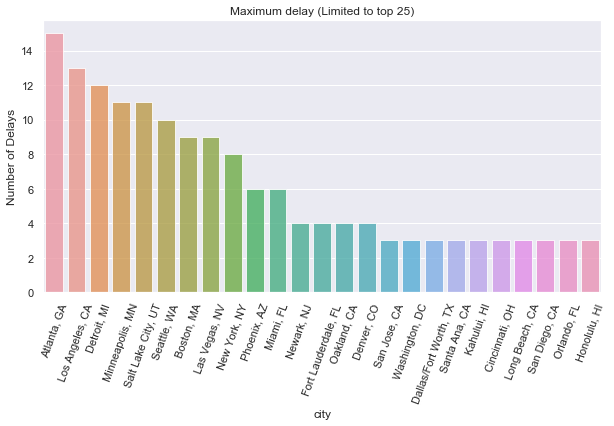

In [77]:
#df.groupby(['destinationcityname']).count()['CarrierDelay'].plot(ax=ax)
city_count  = df['destinationcityname'].value_counts()
city_count = city_count[:25,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Maximum delay (Limited to top 25) on 01/05/2017')
plt.ylabel('Number of Delays', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.xticks(rotation=70)
plt.show()


In [ ]:
#Query secondary nosql (ES)


### 1.4 What is the min/max and average time between delays by delay type on a given day?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 1.5 Categories the number of delays by delay type

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 1.6 What is the min, max and average time between the planned and actual arrival time of the aircraft by airline?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


## 2. Moderate

### 2.1 What delay type is most common at each airport (over a month, quarter or year)?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 2.2 Did privately managed airlines perform better than publicly traded ones?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 2.3 What airline had the most delays each month?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


## 3. Difficult

### 3.1 How did other airlines (peers) perform during bad weather (over a month, quarter or year)?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 3.2. Is the airline at fault for the delay and should it compensate the customers?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 3.3 Was there any correlation between delay trends and companies stock performance?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)


### 3.4 Did airlines with modernized fleet perform better during bad weather?

In [ ]:
#Query primary nosql (cassandra)


In [ ]:
#Query secondary nosql (ES)
